<a href="https://colab.research.google.com/github/kevinworthington/geospatial_colab/blob/main/google_earth_engine_precipitation_timelapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Earth Engine Precipitation Timelapse animation

This notebook demonstrates how to generate the timelapse animation of [IMERG precipitation dataset](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06). In the animation, you can add map elements such as, title of map, north arrow, map scale, colorbar etc.

In [11]:
%%capture
%pip install cartopy

In [2]:
import geemap
import ee

ee.Authenticate()
ee.Initialize(project="ee-csucentroidtest")

print(geemap.__version__)

0.35.1


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [3]:
m = geemap.Map(center=(0.7893, 113.9213), zoom=5)
m

Map(center=[0.7893, 113.9213], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [4]:
# Extract the required country boundary, in this case Indonesia
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")
indonesia = countries.filter(ee.Filter.eq("ADM0_NAME", "Indonesia"))
indonesia_geom = indonesia.geometry()

# Load the IMERG precipitation data for the desired day
date = ee.Date("2023-07-15")
precipitation_collection = ee.ImageCollection("NASA/GPM_L3/IMERG_V06").filterDate(
    date, date.advance(1, "day")
)


# Define a function to mask out precipitation less than 0.5 mm/hr
def mask_less_ppt(collection):
    masked_collection = collection.map(lambda image: image.updateMask(image.gte(0.5)))
    return masked_collection


# Mask out precipitation less than 0.5 mm/hr
masked_imerg_collection = mask_less_ppt(precipitation_collection)

# add indonesia boundary to map
style = {"color": "000ffff0", "width": 2, "lineType": "solid", "fillColor": "00000000"}
m.addLayer(indonesia.style(**style), {}, "Indonesia_boundary")


# Define visualization parameters
palette = [
    "000096",
    "0064ff",
    "00b4ff",
    "33db80",
    "9beb4a",
    "ffeb00",
    "ffb300",
    "ff6400",
    "eb1e00",
    "af0000",
]
vis_params = {
    "min": 0,
    "max": 50,
    "bands": "precipitationCal",
    "palette": ["000096", "0064ff", "00b4ff", "eb1e00", "af0000"],
}

# # Add the precipitation data to the map
m.addLayer(masked_imerg_collection, vis_params, 'Precipitation (IMERG)')
# m

In [5]:
# clip the precipitation data to the Indonesia boundary
clipped_imerg_collection = masked_imerg_collection.map(
    lambda image: image.clip(indonesia_geom)
)

# Get the number of images in the clipped collection
clipped_imerg_collection.size().getInfo()

48

In [6]:
# get bounding box of indonesia
indonesia_bbox = indonesia.geometry().bounds()
indonesia_bbox

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.bounds",
    "arguments": {
      "geometry": {
        "functionInvocationValue": {
          "functionName": "Collection.geometry",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.filter",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.loadTable",
                      "arguments": {
                        "tableId": {
                          "constantValue": "FAO/GAUL/2015/level0"
                        }
                      }
                    }
                  },
                  "filter": {
                    "functionInvocationValue": {
                      "functionName": "Filter.equals",
                      "arguments": {
                        "leftField": {
                          "constantValue": "ADM0_NAME"
                        },
                        "rightValue": {
                          "constantValue": "Indonesia"
                        }
                      }
                    }
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [7]:
# Display sample image
vis_params = {
    "min": 0,
    "max": 50,
    "bands": "precipitationCal",
    "palette": ["000096", "0064ff", "00b4ff", "eb1e00", "af0000"],
}

# Display the first image in the clipped collection
image = ee.Image(clipped_imerg_collection.first())
m.addLayer(image, vis_params, "First image")

Map(bottom=562.0, center=[65.58572002329473, 340.6640625], controls=(WidgetControl(options=['position', 'trans…

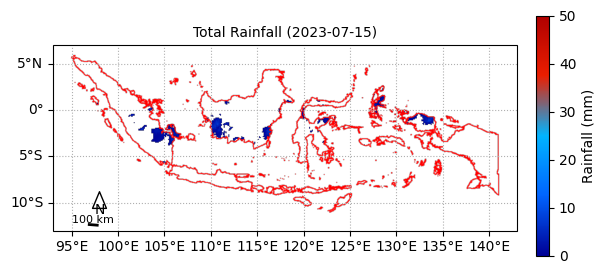

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import json

# import the cartoee functionality from geemap
from geemap import cartoee

# set the width and height of the map
w = 25
h = 10

# set the center of the map
lon = 118
lat = -3

# set the region of interest
region = [lon + w, lat - h, lon - w, lat + h]


# use cartoee to get a map
ax = cartoee.get_map(image, region=region, vis_params=vis_params)

# add the Indonesia boundary to the map
outline_style = {"color": "FF0000", "width": 2, "fillColor": "00000000"}
cartoee.add_layer(
    ax, indonesia.style(**outline_style), region=region, crs=ccrs.PlateCarree()
)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[5, 5], linestyle=":")

# add a colorbar to the map (right side)
cb = cartoee.add_colorbar(
    ax, vis_params, loc="right", label="Rainfall (mm)", orientation="vertical"
)

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.21),
    "arrow_length": 0.10,
    "text_color": "black",
    "arrow_color": "white",
    "fontsize": 10,
    "width": 5,
    "headwidth": 10,
    "ha": "center",
    "va": "center",
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {
    "length": 100,
    "xy": (0.1, 0.05),
    "linewidth": 2,
    "fontsize": 8,
    "color": "black",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

# add title
ax.set_title(label="Total Rainfall (2023-07-15)", fontsize=10)

plt.show()

KeyboardInterrupt: 

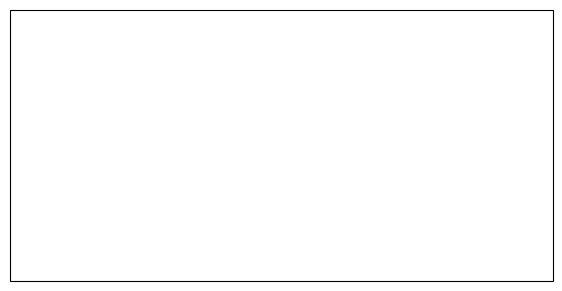

In [13]:
# create a gif of the images in the clipped collection
cartoee.get_image_collection_gif(
    ee_ic=clipped_imerg_collection,
    out_dir="./img/gif_images",
    out_gif="./img/animation.gif",
    vis_params=vis_params,
    region=region,
    fps=2,
    mp4=True,
    grid_interval=(5, 5),
    plot_title="Indonesia Daily Rainfall",
    date_format="YYYY-MM-dd:HH-mm",
    fig_size=(7, 7),
    dpi_plot=100,
    file_format="png",
    overlay_layers=[indonesia],
    overlay_styles=[outline_style],
    colorbar_dict={"loc": "right", "label": "Rainfall (mm)", "orientation": "vertical"},
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)

In [17]:
#to save data to colab, you must first mount your google drive and accept the requested permission
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
#create an interactive map
saved_map=m.save('/content/gdrive/My Drive/geemap.html')


In [23]:
#then unmount the drive
drive.flush_and_unmount()